In [38]:
import os
import sys
import matplotlib.pyplot as plt

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'BlackBox_Attack'))

In [39]:
from attack import *

In [40]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from TabNet import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [41]:
data = pd.read_csv('../../../Dataset/Kaggle-data.csv')
data.head()

/tmp/ipykernel_22447/825226827.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../../Dataset/Kaggle-data.csv')


,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
0,1,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,...,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,NaN
1,2,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,...,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,NaN
2,3,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,...,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,NaN
3,4,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,...,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,NaN
4,5,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,...,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,NaN


In [42]:
data = data.drop(columns=['ID', 'Unnamed: 57'])
data.head()

,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,b69acb3bb133974e48229627663f96d4,332,224,8450,8.0,0,16896,8192,0,16947,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,1cbee4b3725629bd0aa6ac2ff500925f,332,224,258,9.0,0,84480,25600,0,10973,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,b7027cf0cd31c820928950cbfe7e91ef,332,224,8450,8.0,0,4608,3584,0,6452,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,156a0bb069f94d1e7c2508318805f2a4,332,224,8450,10.0,0,108544,15872,0,105021,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,c72bf851fed5542abba904b1f3944cd5,332,224,8226,48.0,0,513024,2048,0,520922,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [43]:
data = data.dropna(axis=1)

In [44]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,SizeOfOptionalHeader,Characteristics,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,0,16896,8192,0,16947,4096,24576,4194304.0,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,0,84480,25600,0,10973,4096,90112,65536.0,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,0,4608,3584,0,6452,4096,12288,264962048.0,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,0,108544,15872,0,105021,4096,114688,268435456.0,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,0,513024,2048,0,520922,8192,524288,268435456.0,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [45]:
def normalize_feature_name(feat_name: str) -> str:
    import re
    # Remove binning patterns like "0.1 < feature <= 3.2", "feature = 1", etc.
    return re.sub(r'([<>]=?|=)\s*[-+]?\d+(\.\d+)?', '', feat_name).strip()

In [46]:
protected_feature = 'Subsystem'

In [47]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='legitimate',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['SizeOfOptionalHeader', 'Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'Subsystem', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNbDLL', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']


In [48]:
numerical_features = ['SizeOfOptionalHeader',
 'Characteristics',
 'MajorLinkerVersion',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MajorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfHeaders',
 'CheckSum',
 'SizeOfStackReserve',
 'SectionsNb',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'ImportsNb',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanEntropy',
 'ResourcesMeanSize',
 'LoadConfigurationSize',
 'VersionInformationSize']

In [49]:
feature_names = list(x_train.columns[:])
class_names = ['Malicious', 'Benign']
feature_names

['SizeOfOptionalHeader',
 'Characteristics',
 'SizeOfCode',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'AddressOfEntryPoint',
 'BaseOfCode',
 'ImageBase',
 'SectionAlignment',
 'FileAlignment',
 'MajorOperatingSystemVersion',
 'MajorImageVersion',
 'MajorSubsystemVersion',
 'MinorSubsystemVersion',
 'SizeOfHeaders',
 'CheckSum',
 'Subsystem',
 'SizeOfStackReserve',
 'SectionsNb',
 'SectionsMeanRawsize',
 'SectionsMinRawsize',
 'ImportsNbDLL',
 'ImportsNb',
 'ExportNb',
 'ResourcesNb',
 'ResourcesMeanEntropy',
 'ResourcesMeanSize',
 'LoadConfigurationSize',
 'VersionInformationSize']

In [50]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [51]:
categorical_features_indices = get_categorical_feature_indices(x_train.columns, numerical_features)
categorical_features = list(x_train.columns[:][categorical_features_indices])
categorical_features

['Subsystem', 'ImportsNbDLL']

In [52]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# For testing data
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Accuracy: 0.9621606631128093
Precision: 0.9621578183571172
Recall: 0.9621606631128093
F-1: 0.9619986479374693


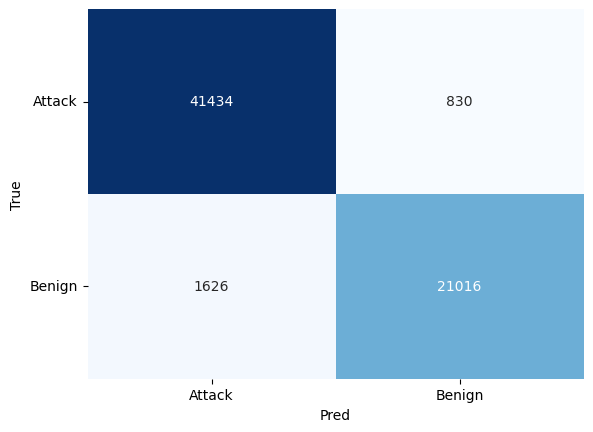

In [53]:
biased_model = base_model_call(
    x_train=x_train,
    y_train=y_train,
    protected_feature=protected_feature,
    keep_protected_feature=True,
    num_epochs=50,
    hidden_sizes=[128, 64],
    dropout_rate=0.3
)
y_pred_biased_model = biased_model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_biased_model)

In [54]:
attacker = BlackBoxIInterpretationAttack(
    target_model=biased_model.pytorch_model,
    generate_explanation_func=lambda m, x, c: my_tabular_explanation_function(m, x, c, 'integrated_gradients'),
    scaler=scaler, # Pass the fitted scaler
    scaled_feature_names=feature_names, # All feature names were scaled
    all_feature_names=feature_names, # All original feature names
    numerical_feature_names_for_perturbation=numerical_features, # All are perturbable
    categorical_feature_names=categorical_features, # Empty list for Iris
    device='cpu'
)


Features allowed for perturbation: ['SizeOfOptionalHeader', 'Characteristics', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']
Categorical features (will not be perturbed): ['Subsystem', 'ImportsNbDLL']


In [55]:
results, asr = attacker.run_attack(test_dataloader, num_samples_to_attack=50, C=0.1)
print(f"Final Attack Success Rate: {asr:.2%}")


Starting attack...
Collected 100 samples and explanations in 5.07 seconds.
Approximating manifolds with UMAP...


/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Manifolds approximated in 0.36 seconds.
  Attack for sample 1/50 took 612.29s, Success: False
  Attack for sample 2/50 took 2319.89s, Success: False
  Attack for sample 3/50 took 2458.39s, Success: False
  Attack for sample 4/50 took 2908.31s, Success: False
  Attack for sample 5/50 took 3249.06s, Success: False
  Attack for sample 6/50 took 546.49s, Success: False
  Attack for sample 7/50 took 1900.80s, Success: False
  Attack for sample 8/50 took 7346.91s, Success: False
  Attack for sample 9/50 took 735.72s, Success: False
  Attack for sample 10/50 took 434.25s, Success: False
  Attack for sample 11/50 took 3179.26s, Success: False
  Attack for sample 12/50 took 2180.70s, Success: False
  Attack for sample 13/50 took 414.10s, Success: False
  Attack for sample 14/50 took 412.22s, Success: False
  Attack for sample 15/50 took 2855.49s, Success: False
  Attack for sample 16/50 took 7503.05s, Success: False
  Attack for sample 17/50 took 404.80s, Success: False
  Attack for sample 18/5

In [ ]:
if attacker.attack_results: # Check if any successful attacks were stored
    print(f"\nFound {len(attacker.attack_results)} successful attacks.")

    # Plot each successful attack with and without target explanation
    for i, (original, x_adv, target_exp, result) in enumerate(attacker.attack_results):
        print(f"\n--- Plotting for Successful Attack {i+1} (Index {i}) ---")

        print(f"Plotting for Attack Index {i} WITHOUT target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=False)

        print(f"Plotting for Attack Index {i} WITH target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=True)

else:
    print("\nNo successful attack found to visualize. Try increasing num_samples_to_attack or adjusting C or max_iter.")


No successful attack found to visualize. Try increasing num_samples_to_attack or adjusting C or max_iter.
